# SAX circuit simulator

[SAX](https://flaport.github.io/sax/) is a circuit solver written in JAX, writing your component models in SAX enables you not only to get the function values but the gradients, this is useful for circuit optimization.

This tutorial has been adapted from the SAX Quick Start.

You can install sax with pip (read the SAX install instructions [here](https://github.com/flaport/sax#installation))

```
! pip install sax
```

In [1]:
import gdsfactory as gf
import gdsfactory.simulation.sax as gs
import gdsfactory.simulation.modes as gm
import matplotlib.pyplot as plt
import sax

gf.config.set_plot_options(show_subports=False)

2022-11-27 23:47:35.363 | INFO     | gdsfactory.config:<module>:46 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 6.2.6


Using MPI version 4.0, 1 processes


2022-11-27 23:47:37.387 | INFO     | gdsfactory.simulation.gmeep:<module>:32 - Meep '1.25.0-beta' installed at ['/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/meep']


## Scatter *dictionaries*

The core datastructure for specifying scatter parameters in SAX is a dictionary... more specifically a dictionary which maps a port combination (2-tuple) to a scatter parameter (or an array of scatter parameters when considering multiple wavelengths for example). Such a specific dictionary mapping is called ann `SDict` in SAX (`SDict ≈ Dict[Tuple[str,str], float]`).

Dictionaries are in fact much better suited for characterizing S-parameters than, say, (jax-)numpy arrays due to the inherent sparse nature of scatter parameters. Moreover, dictionaries allow for string indexing, which makes them much more pleasant to use in this context.

```
o2            o3
   \        /
    ========
   /        \
o1            o4
```

In [2]:
coupling = 0.5
kappa = coupling**0.5
tau = (1 - coupling) ** 0.5
coupler_dict = {
    ("o1", "o4"): tau,
    ("o4", "o1"): tau,
    ("o1", "o3"): 1j * kappa,
    ("o3", "o1"): 1j * kappa,
    ("o2", "o4"): 1j * kappa,
    ("o4", "o2"): 1j * kappa,
    ("o2", "o3"): tau,
    ("o3", "o2"): tau,
}
coupler_dict

{('o1', 'o4'): 0.7071067811865476,
 ('o4', 'o1'): 0.7071067811865476,
 ('o1', 'o3'): 0.7071067811865476j,
 ('o3', 'o1'): 0.7071067811865476j,
 ('o2', 'o4'): 0.7071067811865476j,
 ('o4', 'o2'): 0.7071067811865476j,
 ('o2', 'o3'): 0.7071067811865476,
 ('o3', 'o2'): 0.7071067811865476}

 it can still be tedious to specify every port in the circuit manually. SAX therefore offers the `reciprocal` function, which auto-fills the reverse connection if the forward connection exist. For example:

In [3]:
coupler_dict = sax.reciprocal(
    {
        ("o1", "o4"): tau,
        ("o1", "o3"): 1j * kappa,
        ("o2", "o4"): 1j * kappa,
        ("o2", "o3"): tau,
    }
)

coupler_dict

{('o1', 'o4'): 0.7071067811865476,
 ('o1', 'o3'): 0.7071067811865476j,
 ('o2', 'o4'): 0.7071067811865476j,
 ('o2', 'o3'): 0.7071067811865476,
 ('o4', 'o1'): 0.7071067811865476,
 ('o3', 'o1'): 0.7071067811865476j,
 ('o4', 'o2'): 0.7071067811865476j,
 ('o3', 'o2'): 0.7071067811865476}

## Parametrized Models

Constructing such an `SDict` is easy, however, usually we're more interested in having parametrized models for our components. To parametrize the coupler `SDict`, just wrap it in a function to obtain a SAX `Model`, which is a keyword-only function mapping to an `SDict`:

In [4]:
def coupler(coupling=0.5) -> sax.SDict:
    kappa = coupling**0.5
    tau = (1 - coupling) ** 0.5
    return sax.reciprocal(
        {
            ("o1", "o4"): tau,
            ("o1", "o3"): 1j * kappa,
            ("o2", "o4"): 1j * kappa,
            ("o2", "o3"): tau,
        }
    )


coupler(coupling=0.3)

{('o1', 'o4'): 0.8366600265340756,
 ('o1', 'o3'): 0.5477225575051661j,
 ('o2', 'o4'): 0.5477225575051661j,
 ('o2', 'o3'): 0.8366600265340756,
 ('o4', 'o1'): 0.8366600265340756,
 ('o3', 'o1'): 0.5477225575051661j,
 ('o4', 'o2'): 0.5477225575051661j,
 ('o3', 'o2'): 0.8366600265340756}

In [5]:
def waveguide(wl=1.55, wl0=1.55, neff=2.34, ng=3.4, length=10.0, loss=0.0) -> sax.SDict:
    dwl = wl - wl0
    dneff_dwl = (ng - neff) / wl0
    neff = neff - dwl * dneff_dwl
    phase = 2 * jnp.pi * neff * length / wl
    transmission = 10 ** (-loss * length / 20) * jnp.exp(1j * phase)
    return sax.reciprocal(
        {
            ("o1", "o2"): transmission,
        }
    )

### Waveguide model

You can create a dispersive waveguide model in SAX.

Lets compute the effective index `neff` and group index `ng` for a 1550nm 500nm straight waveguide

In [6]:
m = gm.find_mode_dispersion(wavelength=1.55)
print(m.neff, m.ng)

INFO:rich:Using client version: 1.7.1


2022-11-27 23:47:37.853 | INFO     | gdsfactory.simulation.gtidy3d:<module>:54 - Tidy3d '1.7.1' installed at ['/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/tidy3d']


2.355373317200708 4.2703668980671114


In [7]:
straight_sc = gf.partial(gs.models.straight, neff=m.neff, ng=m.ng)

(-1.0, 1.0)

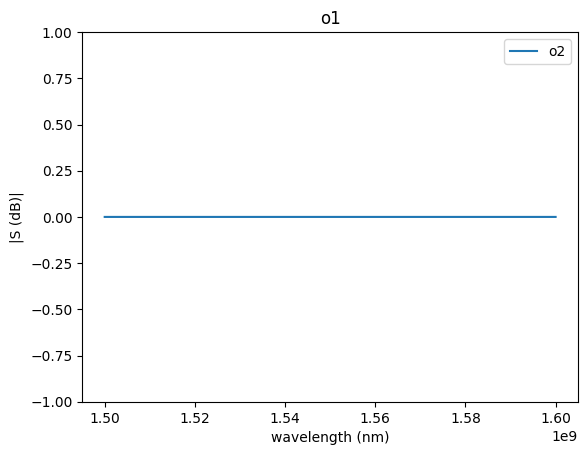

In [8]:
gs.plot_model(straight_sc)
plt.ylim(-1, 1)

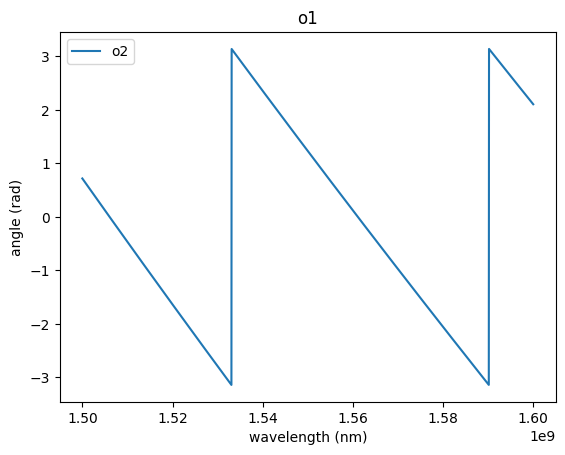

In [9]:
gs.plot_model(straight_sc, phase=True)

### Coupler model

In [10]:
gm.find_coupling_vs_gap?

In [11]:
df = gm.find_coupling_vs_gap()
df

  0%|          | 0/12 [00:00<?, ?it/s]

,gap,ne,no,lc,dn
0,0.200000,2.457893,2.437607,38.202268,0.020287
1,0.218182,2.459030,2.441121,43.276286,0.017908
2,0.236364,2.452194,2.437659,53.319585,0.014535
3,0.254545,2.451945,2.439549,62.518874,0.012396
4,0.272727,2.451249,2.441058,76.046705,0.010191
5,0.290909,2.451496,2.442325,84.505360,0.009171
6,0.309091,2.449447,2.441517,97.724262,0.007930
7,0.327273,2.447256,2.440698,118.172655,0.006558
8,0.345455,2.451724,2.446248,141.519584,0.005476
9,0.363636,2.451128,2.446210,157.598147,0.004918


For a 200nm gap the effective index difference `dn` is `0.02`, which means that there is 100% power coupling over 38.2um

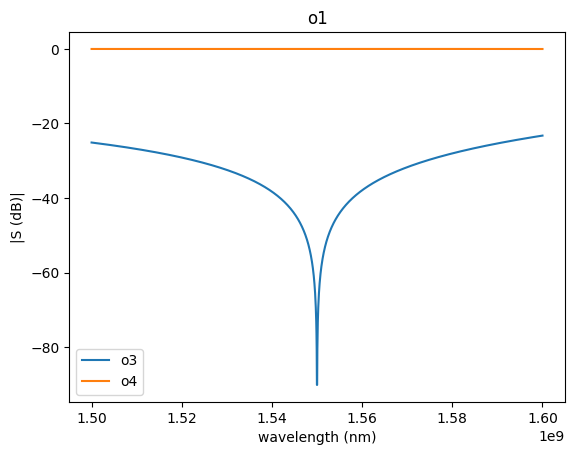

In [12]:
coupler_sc = gf.partial(gs.models.coupler, dn=0.02, length=0, coupling0=0)
gs.plot_model(coupler_sc)

If we ignore the coupling from the bend `coupling0 = 0` we know that for a 3dB coupling we need half of the `lc` length, which is the length needed to coupler `100%` of power.

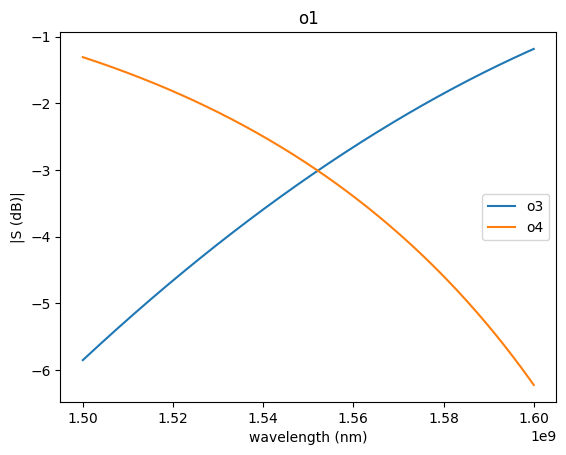

In [13]:
coupler_sc = gf.partial(gs.models.coupler, dn=0.02, length=38.2 / 2, coupling0=0)
gs.plot_model(coupler_sc)

### FDTD Sparameters model

You can also fit a model from Sparameter FDTD simulation data.

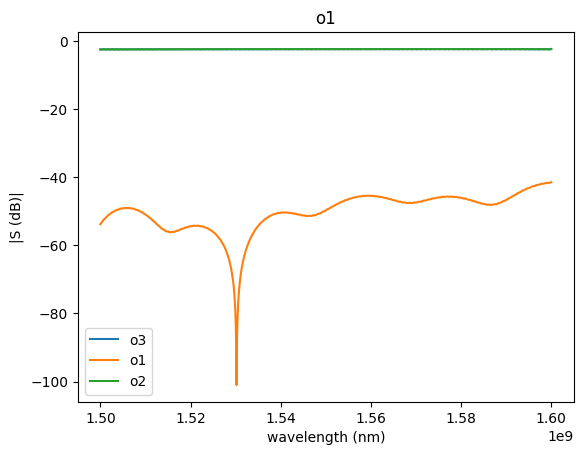

In [14]:
from gdsfactory.simulation.get_sparameters_path import get_sparameters_path_lumerical

filepath = get_sparameters_path_lumerical(gf.c.mmi1x2)
mmi1x2 = gs.read.model_from_npz(filepath=filepath)
gs.plot_model(mmi1x2)

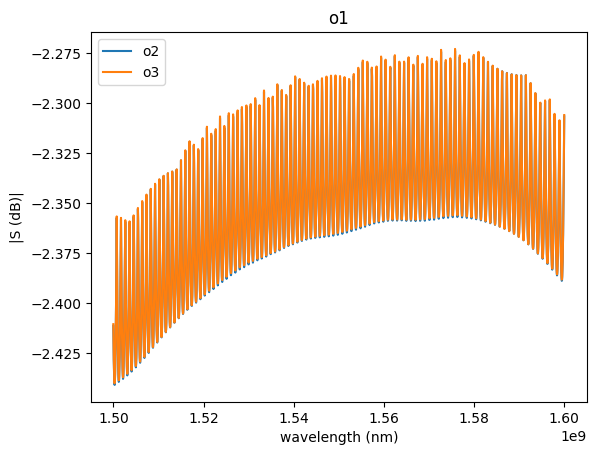

In [15]:
gs.plot_model(mmi1x2, ports2=("o2", "o3"))

## Model fit

You can fit a sax model to Sparameter FDTD simulation data.

In [16]:
import jax
import jax.numpy as jnp
import jax.example_libraries.optimizers as opt
import matplotlib.pyplot as plt

import gdsfactory as gf
import gdsfactory.simulation.modes as gm
import gdsfactory.simulation.sax as gs

In [17]:
coupler_fdtd = gs.read.model_from_csv(
    filepath=gf.config.sparameters_path / "coupler" / "coupler_G224n_L20_S220.csv",
    xkey="wavelength_nm",
    prefix="S",
    xunits=1e-3,
)

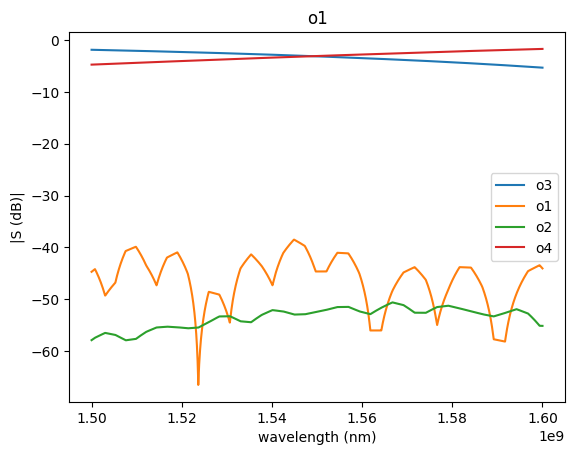

In [18]:
gs.plot_model(coupler_fdtd)

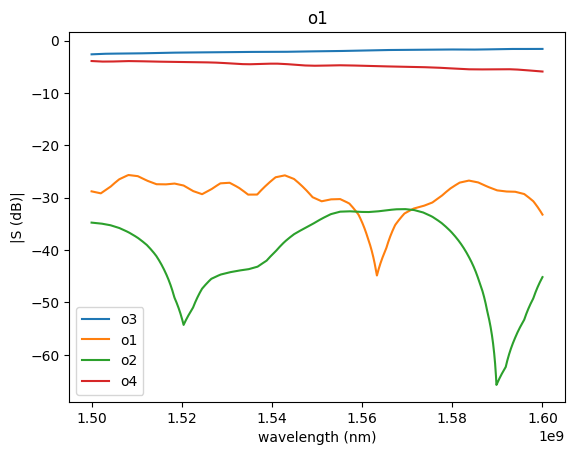

In [19]:
# lumerical simulation (different coupler)
coupler_fdtd = gs.read.model_from_csv(
    filepath=gf.config.sparameters_path / "coupler_057254c0_00cc8908.csv",
)
gs.plot_model(coupler_fdtd)

Lets fit the coupler spectrum with a linear regression `sklearn` fit

In [20]:
import sax
import gdsfactory as gf
import gdsfactory.simulation.sax as gs
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.constants import c
from sklearn.linear_model import LinearRegression

In [21]:
f = jnp.linspace(c / 1.0e-6, c / 2.0e-6, 500) * 1e-12  # THz
wl = c / (f * 1e12) * 1e6  # um

filepath = gf.config.sparameters_path / "coupler" / "coupler_G224n_L20_S220.csv"
coupler_fdtd = gs.read.model_from_csv(
    filepath, xkey="wavelength_nm", prefix="S", xunits=1e-3
)
sd = coupler_fdtd(wl=wl)

k = sd["o1", "o3"]
t = sd["o1", "o4"]
s = t + k
a = t - k

/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


Lets fit the symmetric (t+k) and antisymmetric (t-k) transmission

### Symmetric

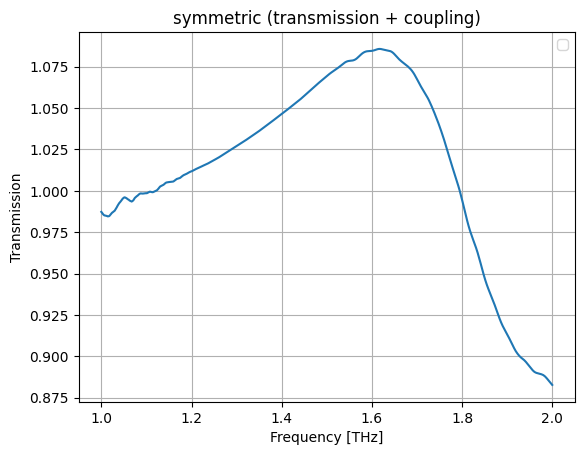

In [22]:
plt.plot(wl, jnp.abs(s))
plt.grid(True)
plt.xlabel("Frequency [THz]")
plt.ylabel("Transmission")
plt.title("symmetric (transmission + coupling)")
plt.legend()
plt.show()

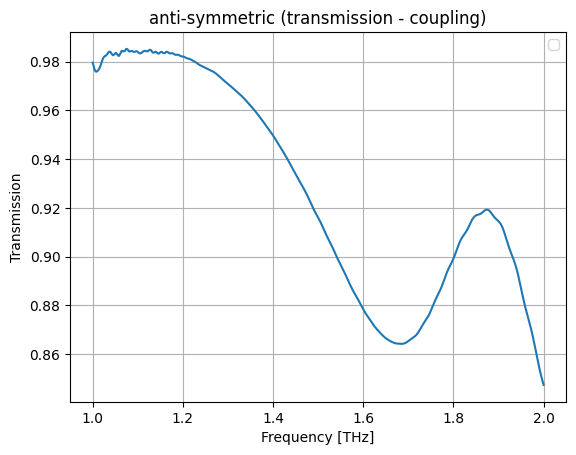

In [23]:
plt.plot(wl, jnp.abs(a))
plt.grid(True)
plt.xlabel("Frequency [THz]")
plt.ylabel("Transmission")
plt.title("anti-symmetric (transmission - coupling)")
plt.legend()
plt.show()

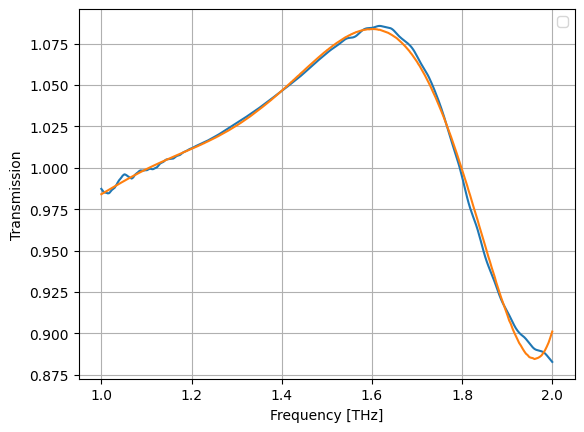

In [24]:
r = LinearRegression()
fX = lambda x, _order=8: x[:, None] ** (
    jnp.arange(_order)[None, :]
)  # artificially create more 'features' (wl**2, wl**3, wl**4, ...)
X = fX(wl)
r.fit(X, jnp.abs(s))
asm, bsm = r.coef_, r.intercept_
fsm = lambda x: fX(x) @ asm + bsm  # fit symmetric module fiir

plt.plot(wl, jnp.abs(s))
plt.plot(wl, fsm(wl))
plt.grid(True)
plt.xlabel("Frequency [THz]")
plt.ylabel("Transmission")
plt.legend()
plt.show()

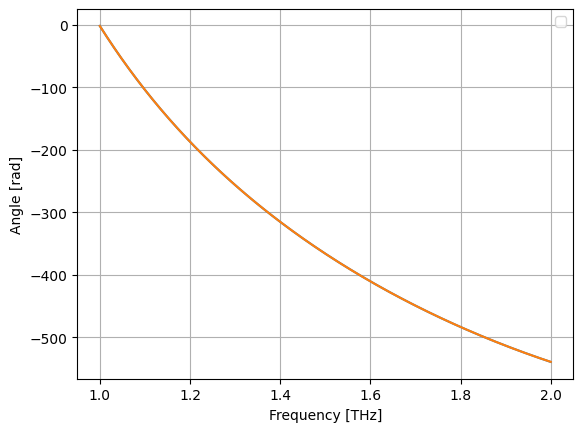

In [25]:
r = LinearRegression()
r.fit(X, jnp.unwrap(jnp.angle(s)))
asp, bsp = r.coef_, r.intercept_
fsp = lambda x: fX(x) @ asp + bsp  # fit symmetric phase

plt.plot(wl, jnp.unwrap(jnp.angle(s)))
plt.plot(wl, fsp(wl))
plt.grid(True)
plt.xlabel("Frequency [THz]")
plt.ylabel("Angle [rad]")
plt.legend()
plt.show()

In [26]:
fs = lambda x: fsm(x) * jnp.exp(1j * fsp(x))

Lets fit the symmetric (t+k) and antisymmetric (t-k) transmission

### Anti-Symmetric

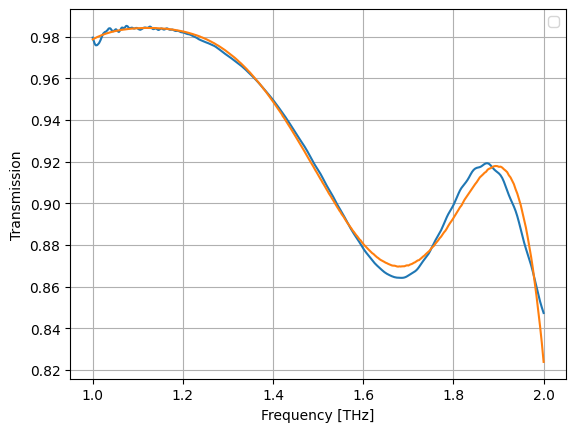

In [27]:
r = LinearRegression()
r.fit(X, jnp.abs(a))
aam, bam = r.coef_, r.intercept_
fam = lambda x: fX(x) @ aam + bam

plt.plot(wl, jnp.abs(a))
plt.plot(wl, fam(wl))
plt.grid(True)
plt.xlabel("Frequency [THz]")
plt.ylabel("Transmission")
plt.legend()
plt.show()

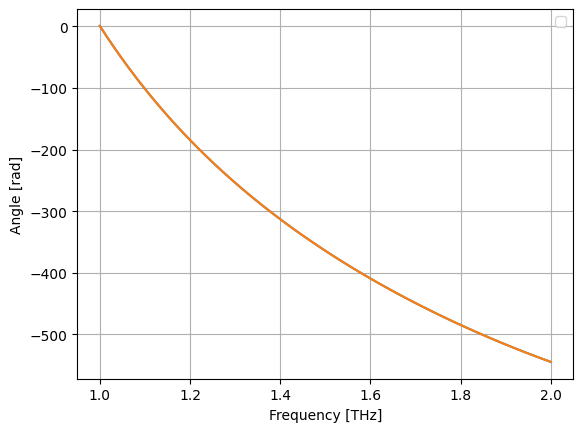

In [28]:
r = LinearRegression()
r.fit(X, jnp.unwrap(jnp.angle(a)))
aap, bap = r.coef_, r.intercept_
fap = lambda x: fX(x) @ aap + bap

plt.plot(wl, jnp.unwrap(jnp.angle(a)))
plt.plot(wl, fap(wl))
plt.grid(True)
plt.xlabel("Frequency [THz]")
plt.ylabel("Angle [rad]")
plt.legend()
plt.show()

In [29]:
fa = lambda x: fam(x) * jnp.exp(1j * fap(x))

### Total

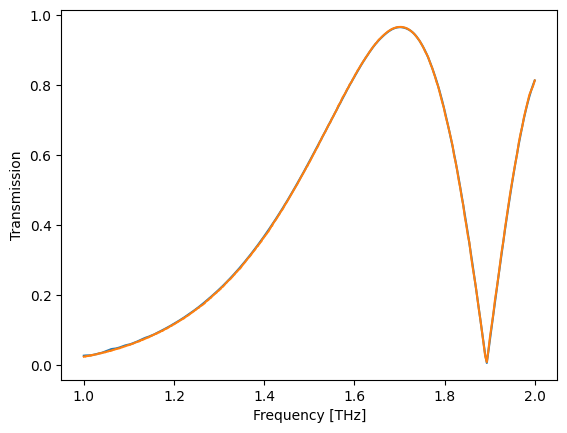

In [30]:
t_ = 0.5 * (fs(wl) + fa(wl))

plt.plot(wl, jnp.abs(t))
plt.plot(wl, jnp.abs(t_))
plt.xlabel("Frequency [THz]")
plt.ylabel("Transmission")

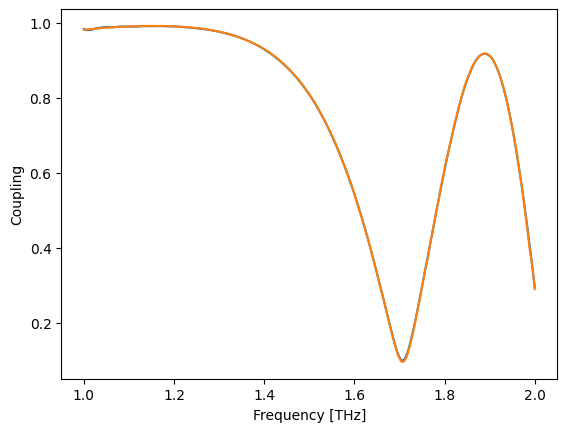

In [31]:
k_ = 0.5 * (fs(wl) - fa(wl))

plt.plot(wl, jnp.abs(k))
plt.plot(wl, jnp.abs(k_))
plt.xlabel("Frequency [THz]")
plt.ylabel("Coupling")

In [32]:
@jax.jit
def coupler(wl=1.5):
    wl = jnp.asarray(wl)
    wl_shape = wl.shape
    wl = wl.ravel()
    t = (0.5 * (fs(wl) + fa(wl))).reshape(*wl_shape)
    k = (0.5 * (fs(wl) - fa(wl))).reshape(*wl_shape)
    sdict = {
        ("o1", "o4"): t,
        ("o1", "o3"): k,
        ("o2", "o3"): k,
        ("o2", "o4"): t,
    }
    return sax.reciprocal(sdict)

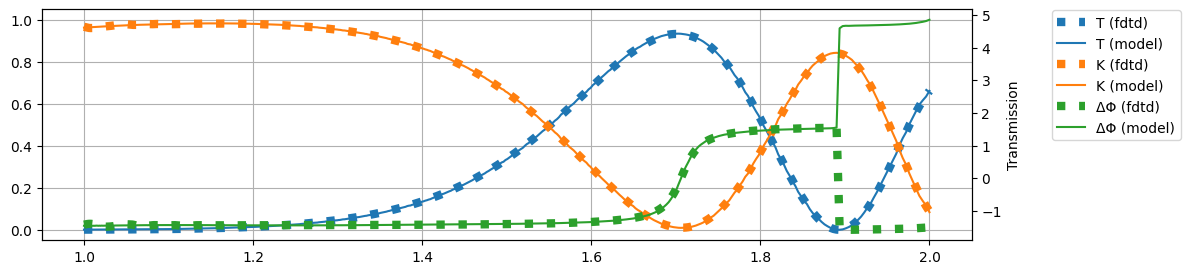

In [33]:
f = jnp.linspace(c / 1.0e-6, c / 2.0e-6, 500) * 1e-12  # THz
wl = c / (f * 1e12) * 1e6  # um

filepath = gf.config.sparameters_path / "coupler" / "coupler_G224n_L20_S220.csv"
coupler_fdtd = gs.read.model_from_csv(
    filepath, xkey="wavelength_nm", prefix="S", xunits=1e-3
)
sd = coupler_fdtd(wl=wl)
sd_ = coupler(wl=wl)

T = jnp.abs(sd["o1", "o4"]) ** 2
K = jnp.abs(sd["o1", "o3"]) ** 2
T_ = jnp.abs(sd_["o1", "o4"]) ** 2
K_ = jnp.abs(sd_["o1", "o3"]) ** 2
dP = jnp.unwrap(jnp.angle(sd["o1", "o3"]) - jnp.angle(sd["o1", "o4"]))
dP_ = jnp.unwrap(jnp.angle(sd_["o1", "o3"]) - jnp.angle(sd_["o1", "o4"]))

plt.figure(figsize=(12, 3))
plt.plot(wl, T, label="T (fdtd)", c="C0", ls=":", lw="6")
plt.plot(wl, T_, label="T (model)", c="C0")

plt.plot(wl, K, label="K (fdtd)", c="C1", ls=":", lw="6")
plt.plot(wl, K_, label="K (model)", c="C1")

plt.ylim(-0.05, 1.05)
plt.grid(True)

plt.twinx()
plt.plot(wl, dP, label="ΔΦ (fdtd)", color="C2", ls=":", lw="6")
plt.plot(wl, dP_, label="ΔΦ (model)", color="C2")

plt.xlabel("Frequency [THz]")
plt.ylabel("Transmission")
plt.figlegend(bbox_to_anchor=(1.08, 0.9))
plt.savefig("fdtd_vs_model.png", bbox_inches="tight")
plt.show()

## SAX gdsfactory Compatibility
> From Layout to Circuit Model

If you define your SAX S parameter models for your components, you can directly simulate your circuits from gdsfactory

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from omegaconf import OmegaConf
import sax
from pprint import pprint

import gdsfactory as gf
from gdsfactory.get_netlist import get_netlist as _get_netlist

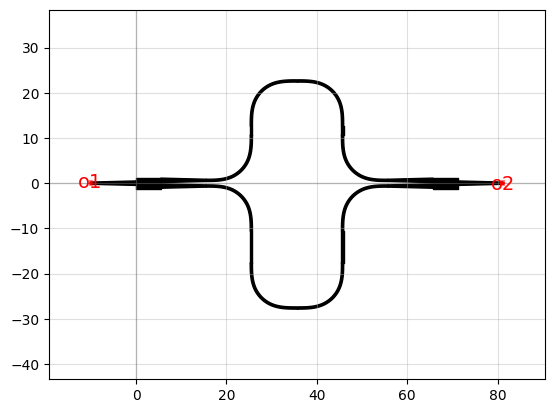

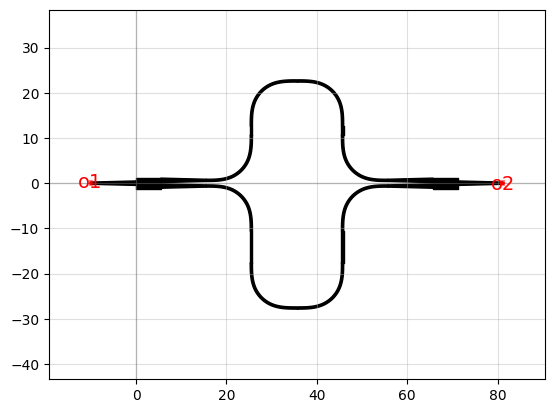

mzi_delta_length10: uid 653f09a1, ports ['o1', 'o2'], references ['bend_euler_1', 'bend_euler_2', 'bend_euler_3', 'bend_euler_4', 'bend_euler_5', 'bend_euler_6', 'straight_5', 'straight_6', 'straight_7', 'bend_euler_7', 'bend_euler_8', 'straight_8', 'straight_9', 'straight_10', 'sytl', 'syl', 'sxt', 'sxb', 'cp1', 'cp2'], 0 polygons

In [35]:
mzi = gf.components.mzi(delta_length=10)
mzi

In [36]:
netlist = mzi.get_netlist()
pprint(netlist["connections"])

{'bend_euler_1,o1': 'cp1,o3',
 'bend_euler_1,o2': 'syl,o1',
 'bend_euler_2,o1': 'syl,o2',
 'bend_euler_2,o2': 'sxb,o1',
 'bend_euler_3,o1': 'cp1,o2',
 'bend_euler_3,o2': 'sytl,o1',
 'bend_euler_4,o1': 'sxt,o1',
 'bend_euler_4,o2': 'sytl,o2',
 'bend_euler_5,o1': 'straight_5,o2',
 'bend_euler_5,o2': 'straight_6,o1',
 'bend_euler_6,o1': 'straight_6,o2',
 'bend_euler_6,o2': 'straight_7,o1',
 'bend_euler_7,o1': 'straight_8,o2',
 'bend_euler_7,o2': 'straight_9,o1',
 'bend_euler_8,o1': 'straight_9,o2',
 'bend_euler_8,o2': 'straight_10,o1',
 'cp2,o2': 'straight_7,o2',
 'cp2,o3': 'straight_10,o2',
 'straight_5,o1': 'sxt,o2',
 'straight_8,o1': 'sxb,o2'}


The netlist has three different components:

1. straight
2. mmi1x2
3. bend_euler

You need models for each subcomponents to simulate the Component.

In [37]:
def straight(wl=1.5, length=10.0, neff=2.4) -> sax.SDict:
    wl0 = 1.5  # center wavelength for which the waveguide model is defined
    return sax.reciprocal({("o1", "o2"): jnp.exp(2j * jnp.pi * neff * length / wl)})


def mmi1x2():
    """Assumes a perfect 1x2 splitter"""
    return sax.reciprocal(
        {
            ("o1", "o2"): 0.5**0.5,
            ("o1", "o3"): 0.5**0.5,
        }
    )


def bend_euler(wl=1.5, length=20.0):
    """ "Let's assume a reduced transmission for the euler bend compared to a straight"""
    return {k: 0.99 * v for k, v in straight(wl=wl, length=length).items()}


models = {
    "bend_euler": bend_euler,
    "mmi1x2": mmi1x2,
    "straight": straight,
}

In [38]:
circuit, _ = sax.circuit(netlist=netlist, models=models)

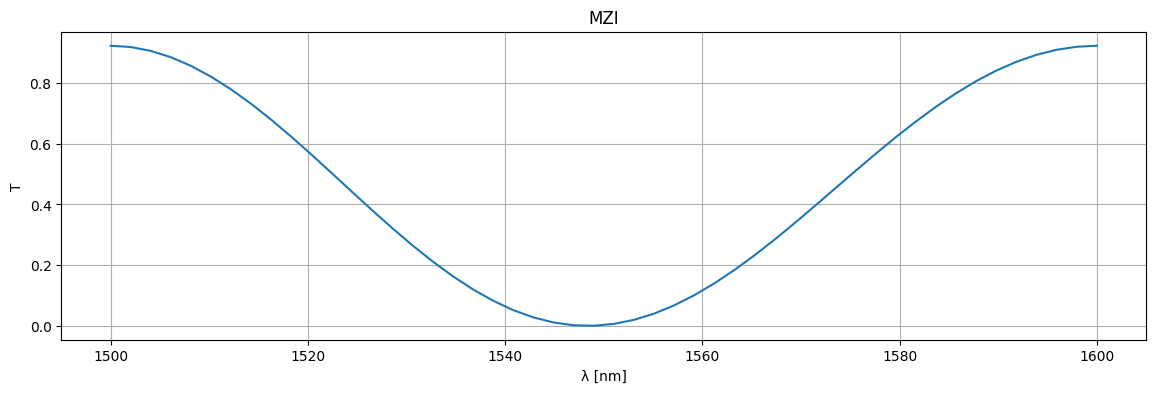

In [39]:
wl = np.linspace(1.5, 1.6)
S = circuit(wl=wl)

plt.figure(figsize=(14, 4))
plt.title("MZI")
plt.plot(1e3 * wl, jnp.abs(S["o1", "o2"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.grid(True)
plt.show()

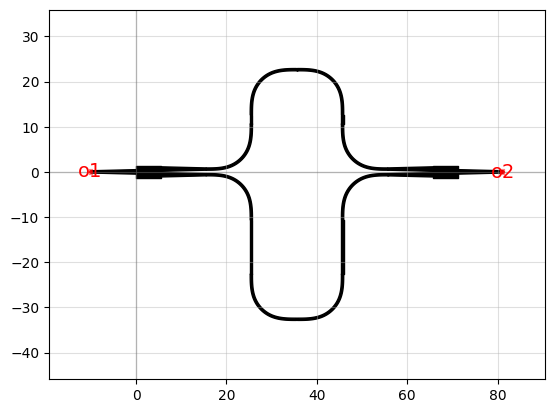

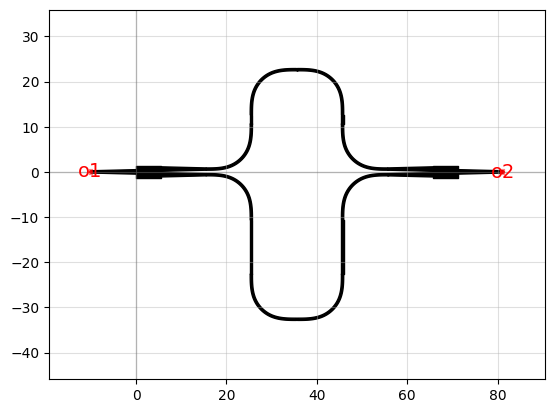

mzi_delta_length20: uid 94e95d55, ports ['o1', 'o2'], references ['bend_euler_1', 'bend_euler_2', 'bend_euler_3', 'bend_euler_4', 'bend_euler_5', 'bend_euler_6', 'straight_5', 'straight_6', 'straight_7', 'bend_euler_7', 'bend_euler_8', 'straight_8', 'straight_9', 'straight_10', 'sytl', 'syl', 'sxt', 'sxb', 'cp1', 'cp2'], 0 polygons

In [40]:
mzi = gf.components.mzi(delta_length=20)  # Double the length, reduces FSR by 1/2
mzi

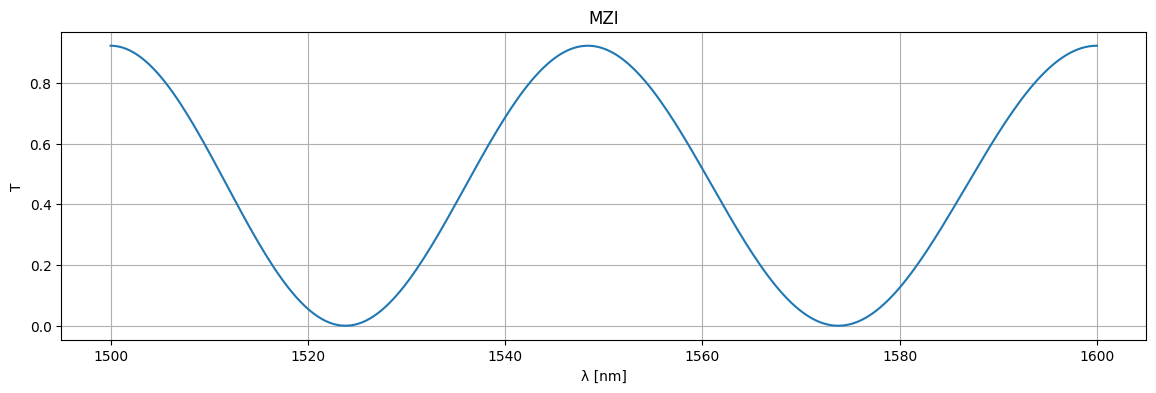

In [41]:
circuit, _ = sax.circuit(netlist=mzi.get_netlist(), models=models)

wl = np.linspace(1.5, 1.6, 256)
S = circuit(wl=wl)

plt.figure(figsize=(14, 4))
plt.title("MZI")
plt.plot(1e3 * wl, jnp.abs(S["o1", "o2"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.grid(True)
plt.show()

## Layout aware Monte Carlo

In [42]:
import itertools
import sys
from functools import partial
from typing import List

import gdsfactory as gf
import jax
import jax.example_libraries.optimizers as opt
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import sax
from numpy.fft import fft2, fftfreq, fftshift, ifft2
from tqdm.notebook import tqdm, trange

### Waveguide Model

The waveguide model is not very good (it just has 100% transmission and no phase).
You can fix the phase calculation.
To do this, you need to find the effective index of the waveguide in relation to its parameters.
You can use MPB mode solver to obtain the waveguide parameters from the waveguide modes thanks to `find_modes_waveguide`.

In [43]:
def silicon_index(wl):
    """a rudimentary silicon refractive index model"""
    a, b = 0.2411478522088102, 3.3229394315868976
    return a / wl + b

In [44]:
from gdsfactory.simulation.modes import find_modes_waveguide

wavelengths = np.linspace(1.5, 1.6, 10)
widths = np.linspace(0.4, 0.6, 5)

wavelengths, widths = np.mgrid[1.5:1.6:10j, 0.4:0.6:5j]
neffs = np.zeros_like(wavelengths)
neffs_ = neffs.ravel()

for i, (wl, w) in enumerate(zip(tqdm(wavelengths.ravel()), widths.ravel())):
    modes = find_modes_waveguide(
        wavelength=wl,
        wg_width=w,
        mode_number=1,
        wg_thickness=0.22,
        slab_thickness=0.0,
        ncore=silicon_index(wl),
        nclad=1.4,
    )
    neffs_[i] = modes[1].neff

  0%|          | 0/50 [00:00<?, ?it/s]

In [45]:
def visualize_mode(mode, field):
    field, comp = list(field)
    idx = ["x", "y", "z"].index(comp)
    x, y = getattr(mode, "y"), getattr(mode, "z")
    Y, X = np.meshgrid(y, x)
    mode = np.abs(getattr(mode, field)[..., 0, idx]) ** 2
    plt.contour(
        X, Y, mode, cmap="inferno", levels=np.linspace(mode.min(), mode.max(), 8)
    )
    plt.colorbar(label="mode")
    plt.grid(True, alpha=0.4)
    plt.xlim(X.min(), X.max())
    plt.ylim(Y.min(), Y.max())
    plt.xlabel("y")
    plt.ylabel("z")
    plt.axis("scaled")
    plt.grid(True)
    plt.show()

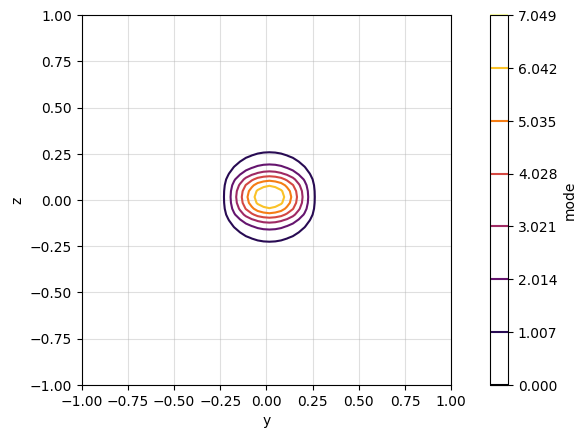

In [46]:
visualize_mode(modes[1], "Hz")

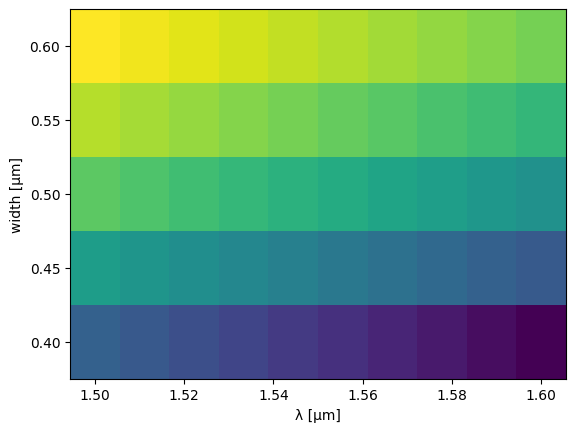

In [47]:
plt.pcolormesh(wavelengths, widths, neffs)
plt.xlabel("λ [μm]")
plt.ylabel("width [μm]")
plt.show()

In [48]:
_grid = [jnp.sort(jnp.unique(wavelengths)), jnp.sort(jnp.unique(widths))]
_data = jnp.asarray(neffs)


@jax.jit
def _get_coordinate(arr1d: jnp.ndarray, value: jnp.ndarray):
    return jnp.interp(value, arr1d, jnp.arange(arr1d.shape[0]))


@jax.jit
def _get_coordinates(arrs1d: List[jnp.ndarray], values: jnp.ndarray):
    # don't use vmap as arrays in arrs1d could have different shapes...
    return jnp.array([_get_coordinate(a, v) for a, v in zip(arrs1d, values)])


@jax.jit
def neff(wl=1.55, width=0.5):
    params = jnp.stack(jnp.broadcast_arrays(jnp.asarray(wl), jnp.asarray(width)), 0)
    coords = _get_coordinates(_grid, params)
    return jax.scipy.ndimage.map_coordinates(_data, coords, 1, mode="nearest")


neff(wl=[1.52, 1.58], width=[0.5, 0.55])

DeviceArray([2.4759295, 2.4804046], dtype=float32)

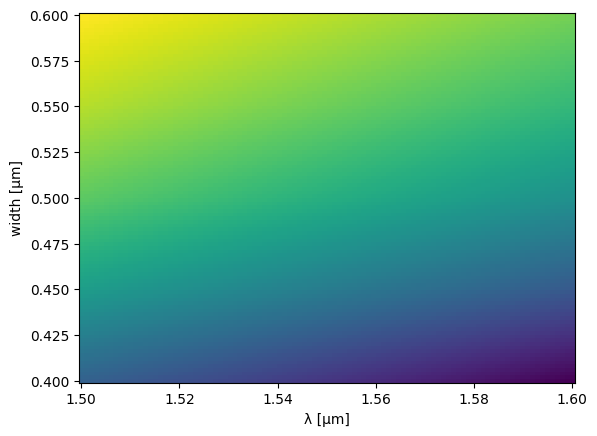

In [49]:
wavelengths_ = np.linspace(wavelengths.min(), wavelengths.max(), 100)
widths_ = np.linspace(widths.min(), widths.max(), 100)
wavelengths_, widths_ = np.meshgrid(wavelengths_, widths_)
neffs_ = neff(wavelengths_, widths_)
plt.pcolormesh(wavelengths_, widths_, neffs_)
plt.xlabel("λ [μm]")
plt.ylabel("width [μm]")
plt.show()

In [50]:
def straight(wl=1.55, length=10.0, width=0.5):
    S = {
        ("o1", "o2"): jnp.exp(2j * np.pi * neff(wl=wl, width=width) / wl * length),
    }
    return sax.reciprocal(S)


def mmi1x2():
    """Assumes a perfect 1x2 splitter"""
    return sax.reciprocal(
        {
            ("o1", "o2"): 0.5**0.5,
            ("o1", "o3"): 0.5**0.5,
        }
    )


def mmi2x2():
    S = {
        ("o1", "o3"): 0.5**0.5,
        ("o1", "o4"): 1j * 0.5**0.5,
        ("o2", "o3"): 1j * 0.5**0.5,
        ("o2", "o4"): 0.5**0.5,
    }
    return sax.reciprocal(S)


def bend_euler(wl=1.5, length=20.0, width=0.5):
    """ "Let's assume a reduced transmission for the euler bend compared to a straight"""
    return {k: 0.99 * v for k, v in straight(wl=wl, length=length, width=width).items()}


models = {
    "bend_euler": bend_euler,
    "mmi1x2": mmi1x2,
    "mmi2x2": mmi2x2,
    "straight": straight,
}

Even though this still is lossless transmission, we're at least modeling the phase correctly.

In [51]:
straight()

{
    ('o1', 'o2'): DeviceArray(-0.01229993-0.99992436j, dtype=complex64),
    ('o2', 'o1'): DeviceArray(-0.01229993-0.99992436j, dtype=complex64)
}

In [52]:
circuit, _ = sax.circuit(mzi.get_netlist(), models=models)
circuit()

{
    ('o1', 'o1'): DeviceArray(0.+0.j, dtype=complex64),
    ('o2', 'o2'): DeviceArray(0.+0.j, dtype=complex64),
    ('o2', 'o1'): DeviceArray(0.00679463+0.00966603j, dtype=complex64),
    ('o1', 'o2'): DeviceArray(0.00679463+0.00966603j, dtype=complex64)
}

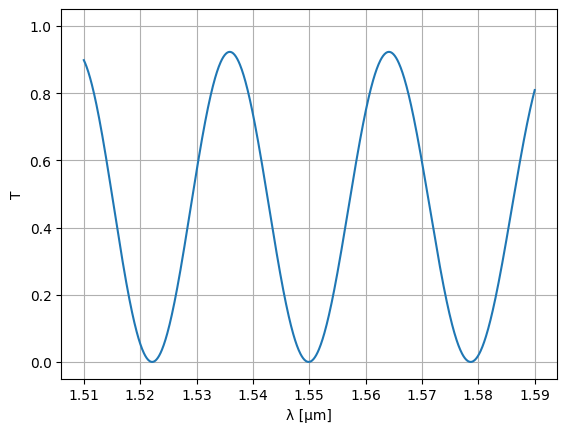

In [53]:
wl = jnp.linspace(1.51, 1.59, 1000)
S = circuit(wl=wl)
plt.plot(wl, abs(S["o1", "o2"]) ** 2)
plt.ylim(-0.05, 1.05)
plt.xlabel("λ [μm]")
plt.ylabel("T")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.show()

### Circuit model with variability

Let's assume the waveguide width changes with a certain correlation length. We can create a 'wafermap' of width variations by randomly varying the width and low pass filtering with a spatial frequency being the inverse of the correlation length (there are probably better ways to do this, but this works for this tutorial).

In [54]:
def create_wafermaps(placements, correlation_length=1.0, num_maps=1, mean=0.0, std=1.0):
    dx = dy = correlation_length / 200
    xs, ys = [p["x"] for p in placements.values()], [
        p["y"] for p in placements.values()
    ]
    xmin, xmax, ymin, ymax = min(xs), max(xs), min(ys), max(ys)
    wx, wy = xmax - xmin, ymax - ymin
    xmin, xmax, ymin, ymax = xmin - wx, xmax + wx, ymin - wy, ymax + wy
    x, y = np.arange(xmin, xmax + dx, dx), np.arange(ymin, ymax + dy, dy)
    W0 = np.random.randn(num_maps, x.shape[0], y.shape[0])

    fx, fy = fftshift(fftfreq(x.shape[0], d=x[1] - x[0])), fftshift(
        fftfreq(y.shape[0], d=y[1] - y[0])
    )
    fY, fX = np.meshgrid(fy, fx)
    fW = fftshift(fft2(W0))

    if correlation_length >= min(x.shape[0], y.shape[0]):
        fW = np.zeros_like(fW)
    else:
        fW = np.where(np.sqrt(fX**2 + fY**2)[None] > 1 / correlation_length, 0, fW)

    W = np.abs(fftshift(ifft2(fW))) ** 2
    mean_ = W.mean(1, keepdims=True).mean(2, keepdims=True)
    std_ = W.std(1, keepdims=True).std(2, keepdims=True)
    if (std_ == 0).all():
        std_ = 1

    W = (W - mean_) / std_
    W = W * std + mean
    return x, y, W

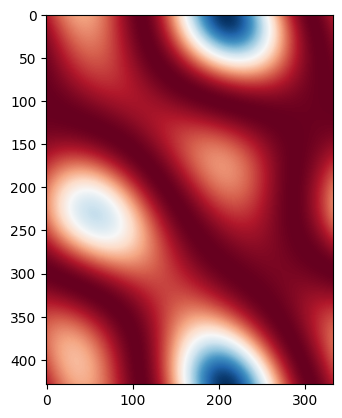

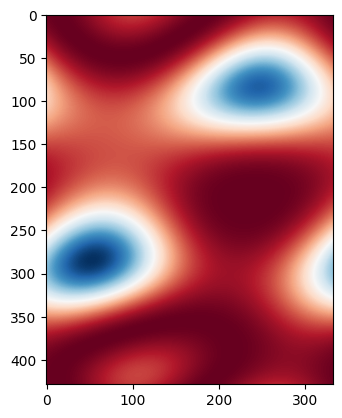

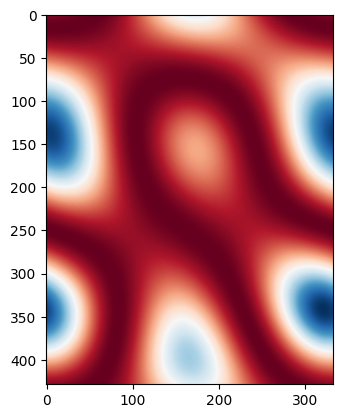

In [55]:
placements = mzi.get_netlist()["placements"]
xm, ym, wmaps = create_wafermaps(
    placements, correlation_length=100, mean=0.5, std=0.002, num_maps=100
)

for i, wmap in enumerate(wmaps):
    plt.imshow(wmap, cmap="RdBu")
    plt.show()
    if i == 2:
        break

In [56]:
def widths(xw, yw, wmaps, x, y):
    _wmap_grid = [xw, yw]
    params = jnp.stack(jnp.broadcast_arrays(jnp.asarray(x), jnp.asarray(y)), 0)
    coords = _get_coordinates(_wmap_grid, params)

    map_coordinates = partial(
        jax.scipy.ndimage.map_coordinates, coordinates=coords, order=1, mode="nearest"
    )
    w = jax.vmap(map_coordinates)(wmaps)
    return w

Let's now sample the MZI width variation on the wafer map (let's assume a single width variation per point):


### Simple MZI

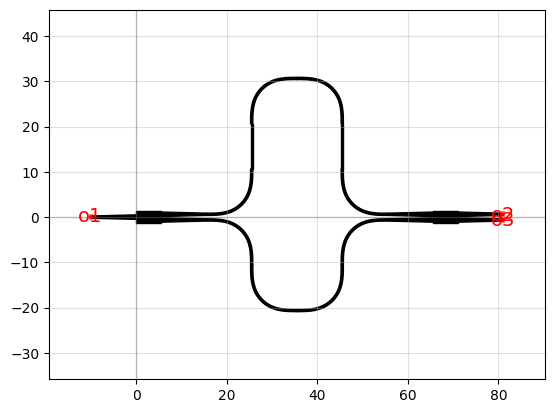

In [57]:
@gf.cell
def simple_mzi():
    global bend_top1_
    c = gf.Component()

    # instances
    mmi_in = gf.components.mmi1x2()
    mmi_out = gf.components.mmi2x2()
    bend = gf.components.bend_euler()
    half_delay_straight = gf.components.straight(length=10.0)

    # references (sax convention: vars ending in underscore are references)
    mmi_in_ = c << mmi_in
    mmi_out_ = c << mmi_out
    straight_top1_ = c << half_delay_straight
    straight_top2_ = c << half_delay_straight
    bend_top1_ = c << bend
    bend_top2_ = (c << bend).mirror()
    bend_top3_ = (c << bend).mirror()
    bend_top4_ = c << bend
    bend_btm1_ = (c << bend).mirror()
    bend_btm2_ = c << bend
    bend_btm3_ = c << bend
    bend_btm4_ = (c << bend).mirror()

    # connections
    bend_top1_.connect("o1", mmi_in_.ports["o2"])
    straight_top1_.connect("o1", bend_top1_.ports["o2"])
    bend_top2_.connect("o1", straight_top1_.ports["o2"])
    bend_top3_.connect("o1", bend_top2_.ports["o2"])
    straight_top2_.connect("o1", bend_top3_.ports["o2"])
    bend_top4_.connect("o1", straight_top2_.ports["o2"])

    bend_btm1_.connect("o1", mmi_in_.ports["o3"])
    bend_btm2_.connect("o1", bend_btm1_.ports["o2"])
    bend_btm3_.connect("o1", bend_btm2_.ports["o2"])
    bend_btm4_.connect("o1", bend_btm3_.ports["o2"])

    mmi_out_.connect("o1", bend_btm4_.ports["o2"])

    # ports
    c.add_port(
        "o1",
        port=mmi_in_.ports["o1"],
    )
    c.add_port("o2", port=mmi_out_.ports["o3"])
    c.add_port("o3", port=mmi_out_.ports["o4"])
    return c


mzi = simple_mzi()
fig = mzi.plot()

In [58]:
circuit, _ = sax.circuit(mzi.get_netlist(), models=models)

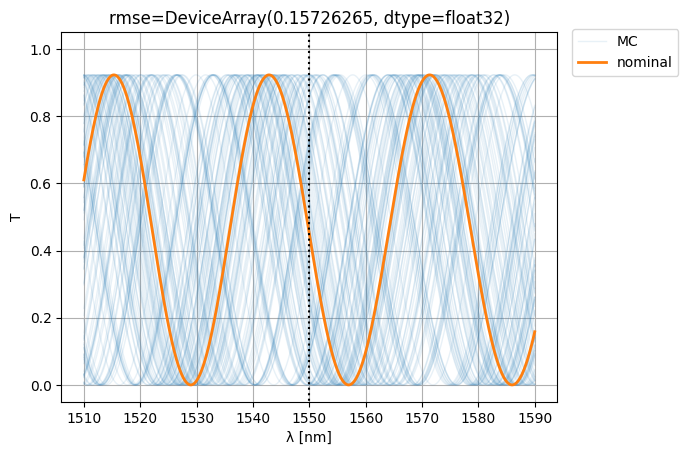

In [59]:
mzi_params = sax.get_settings(circuit)
placements = mzi.get_netlist()["placements"]
width_params = {
    k: {"width": widths(xm, ym, wmaps, v["x"], v["y"])}
    for k, v in placements.items()
    if "width" in mzi_params[k]
}

S0 = circuit(wl=wl)
S = circuit(
    wl=wl[:, None],
    **width_params,
)
ps = plt.plot(wl * 1e3, abs(S["o1", "o2"]) ** 2, color="C0", lw=1, alpha=0.1)
nps = plt.plot(wl * 1e3, abs(S0["o1", "o2"]) ** 2, color="C1", lw=2, alpha=1)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.plot([1550, 1550], [-1, 2], color="black", ls=":")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.figlegend([*ps[-1:], *nps], ["MC", "nominal"], bbox_to_anchor=(1.1, 0.9))
rmse = jnp.mean(
    jnp.abs(jnp.abs(S["o1", "o2"]) ** 2 - jnp.abs(S0["o1", "o2"][:, None]) ** 2) ** 2
)
plt.title(f"{rmse=}")
plt.show()

### Compact MZI

Let's see if we can improve variability (i.e. the RMSE w.r.t. nominal) by making the MZI more compact:

In [60]:
@gf.cell
def compact_mzi():
    c = gf.Component()

    # instances
    mmi_in = gf.components.mmi1x2()
    mmi_out = gf.components.mmi2x2()
    bend = gf.components.bend_euler()
    half_delay_straight = gf.components.straight()
    middle_straight = gf.components.straight(length=6.0)
    half_middle_straight = gf.components.straight(3.0)

    # references (sax convention: vars ending in underscore are references)
    mmi_in_ = c << mmi_in

    bend_top1_ = c << bend
    straight_top1_ = c << half_delay_straight
    bend_top2_ = (c << bend).mirror()
    straight_top2_ = c << middle_straight
    bend_top3_ = (c << bend).mirror()
    straight_top3_ = c << half_delay_straight
    bend_top4_ = c << bend

    straight_btm1_ = c << half_middle_straight
    bend_btm1_ = c << bend
    bend_btm2_ = (c << bend).mirror()
    bend_btm3_ = (c << bend).mirror()
    bend_btm4_ = c << bend
    straight_btm2_ = c << half_middle_straight

    mmi_out_ = c << mmi_out

    # connections
    bend_top1_.connect("o1", mmi_in_.ports["o2"])
    straight_top1_.connect("o1", bend_top1_.ports["o2"])
    bend_top2_.connect("o1", straight_top1_.ports["o2"])
    straight_top2_.connect("o1", bend_top2_.ports["o2"])
    bend_top3_.connect("o1", straight_top2_.ports["o2"])
    straight_top3_.connect("o1", bend_top3_.ports["o2"])
    bend_top4_.connect("o1", straight_top3_.ports["o2"])

    straight_btm1_.connect("o1", mmi_in_.ports["o3"])
    bend_btm1_.connect("o1", straight_btm1_.ports["o2"])
    bend_btm2_.connect("o1", bend_btm1_.ports["o2"])
    bend_btm3_.connect("o1", bend_btm2_.ports["o2"])
    bend_btm4_.connect("o1", bend_btm3_.ports["o2"])
    straight_btm2_.connect("o1", bend_btm4_.ports["o2"])

    mmi_out_.connect("o1", straight_btm2_.ports["o2"])

    # ports
    c.add_port(
        "o1",
        port=mmi_in_.ports["o1"],
    )
    c.add_port("o2", port=mmi_out_.ports["o3"])
    c.add_port("o3", port=mmi_out_.ports["o4"])
    return c

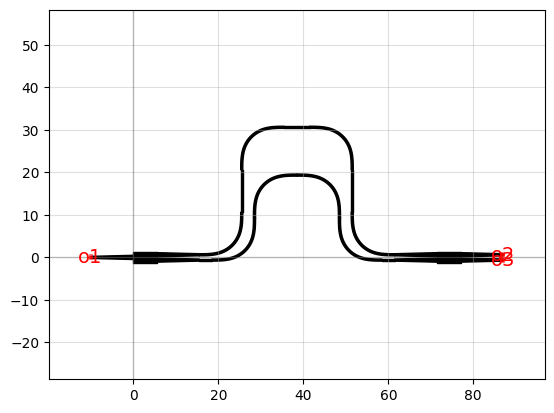

In [61]:
compact_mzi1 = compact_mzi()
fig = compact_mzi1.plot()
placements = compact_mzi1.get_netlist()["placements"]
mzi3, _ = sax.circuit(compact_mzi1.get_netlist(), models=models)

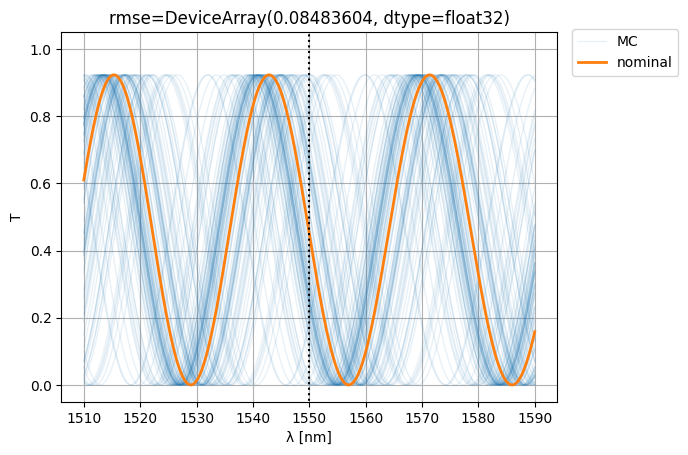

In [62]:
mzi_params = sax.get_settings(mzi3)
placements = compact_mzi1.get_netlist()["placements"]
width_params = {
    k: {"width": widths(xm, ym, wmaps, v["x"], v["y"])}
    for k, v in placements.items()
    if "width" in mzi_params[k]
}

S0 = mzi3(wl=wl)
S = mzi3(
    wl=wl[:, None],
    **width_params,
)
ps = plt.plot(wl * 1e3, abs(S["o1", "o2"]) ** 2, color="C0", lw=1, alpha=0.1)
nps = plt.plot(wl * 1e3, abs(S0["o1", "o2"]) ** 2, color="C1", lw=2, alpha=1)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.plot([1550, 1550], [-1, 2], color="black", ls=":")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.figlegend([*ps[-1:], *nps], ["MC", "nominal"], bbox_to_anchor=(1.1, 0.9))
rmse = jnp.mean(
    jnp.abs(jnp.abs(S["o1", "o2"]) ** 2 - jnp.abs(S0["o1", "o2"][:, None]) ** 2) ** 2
)
plt.title(f"{rmse=}")
plt.show()

## Tuning

You can make a phase shifter model that depends on the applied volage. For that you need first to figure out what's the model associated to your phase shifter, and what is the parameter that you need to tune.

In [63]:
import gdsfactory as gf
import numpy as np
import sax
import matplotlib.pyplot as plt
from tqdm import trange
import jax.numpy as jnp
import jax

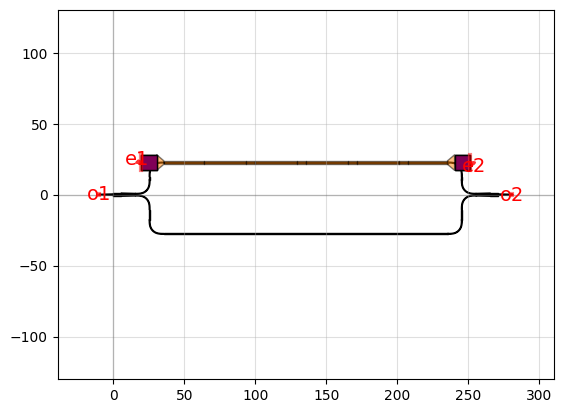

In [64]:
delta_length = 10
mzi_component = gf.components.mzi_phase_shifter_top_heater_metal(
    delta_length=delta_length
)
fig = mzi_component.plot()

In [65]:
def straight(wl=1.5, length=10.0, neff=2.4) -> sax.SDict:
    wl0 = 1.5  # center wavelength for which the waveguide model is defined
    return sax.reciprocal({("o1", "o2"): jnp.exp(2j * jnp.pi * neff * length / wl)})


def mmi1x2() -> sax.SDict:
    """Returns a perfect 1x2 splitter."""
    return sax.reciprocal(
        {
            ("o1", "o2"): 0.5**0.5,
            ("o1", "o3"): 0.5**0.5,
        }
    )


def bend_euler(wl=1.5, length=20.0) -> sax.SDict:
    """Returns bend Sparameters with reduced transmission compared to a straight."""
    return {k: 0.99 * v for k, v in straight(wl=wl, length=length).items()}


def phase_shifter_heater(
    wl: float = 1.55,
    neff: float = 2.34,
    voltage: float = 0,
    length: float = 10,
    loss: float = 0.0,
) -> sax.SDict:
    """Returns simple phase shifter model"""
    deltaphi = voltage * jnp.pi
    phase = 2 * jnp.pi * neff * length / wl + deltaphi
    amplitude = jnp.asarray(10 ** (-loss * length / 20), dtype=complex)
    transmission = amplitude * jnp.exp(1j * phase)
    sdict = sax.reciprocal(
        {
            ("o1", "o2"): transmission,
        }
    )
    return sdict


models = {
    "bend_euler": bend_euler,
    "mmi1x2": mmi1x2,
    "straight": straight,
    "straight_heater_metal_undercut": phase_shifter_heater,
}

In [66]:
mzi_component = gf.components.mzi_phase_shifter_top_heater_metal(
    delta_length=delta_length
)
netlist = mzi_component.get_netlist()
mzi_circuit, _ = sax.circuit(netlist=netlist, models=models)
S = mzi_circuit(wl=1.55)
S

{
    ('o1', 'o1'): DeviceArray(0.+0.j, dtype=complex64),
    ('o2', 'o2'): DeviceArray(0.+0.j, dtype=complex64),
    ('o2', 'o1'): DeviceArray(-0.08826855+0.723444j, dtype=complex64),
    ('o1', 'o2'): DeviceArray(-0.08826858+0.723444j, dtype=complex64)
}

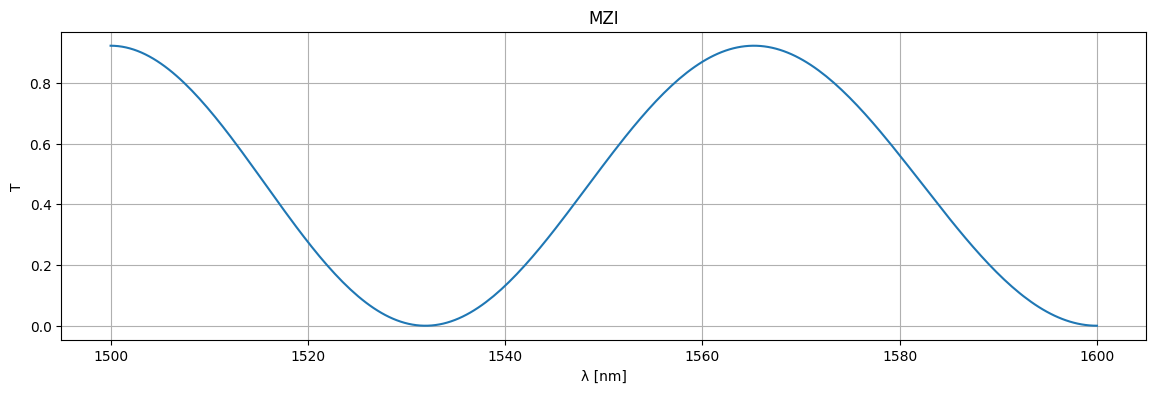

In [67]:
wl = np.linspace(1.5, 1.6, 256)
S = mzi_circuit(wl=wl)

plt.figure(figsize=(14, 4))
plt.title("MZI")
plt.plot(1e3 * wl, jnp.abs(S["o1", "o2"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.grid(True)
plt.show()

Now you can tune the phase shift applied to one of the arms.

How do you find out what's the name of the netlist component that you want to tune?

You can backannotate the netlist and read the labels on the backannotated netlist or you can plot the netlist

<networkx.classes.graph.Graph object at 0x7f17c0e8afd0>

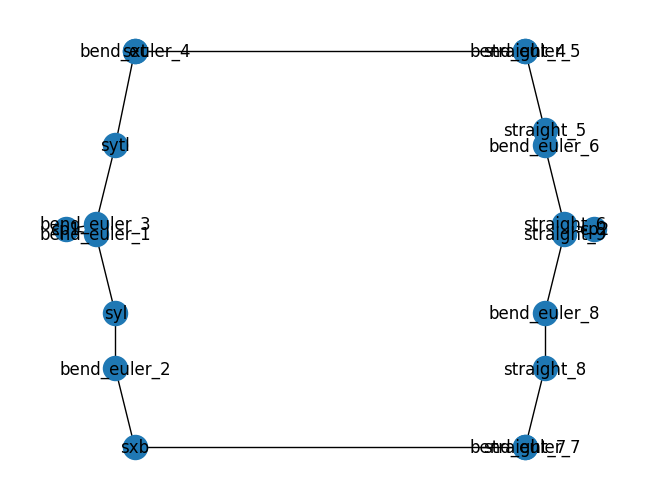

In [68]:
mzi_component.plot_netlist()

As you can see the top phase shifter instance `sxt` is hard to see on the netlist.
You can also reconstruct the component using the netlist and look at the labels in klayout.

/home/runner/work/gdsfactory/gdsfactory/gdsfactory/read/from_yaml.py:674: UserWarning: YAML defined: (bend_euler_3, bend_euler_5, bend_euler_4, bend_euler_6, bend_euler_8, cp2, bend_euler_2, bend_euler_7, straight_4, bend_euler_1, straight_7) with both connection and placement. Please use one or the other.
  warnings.warn(


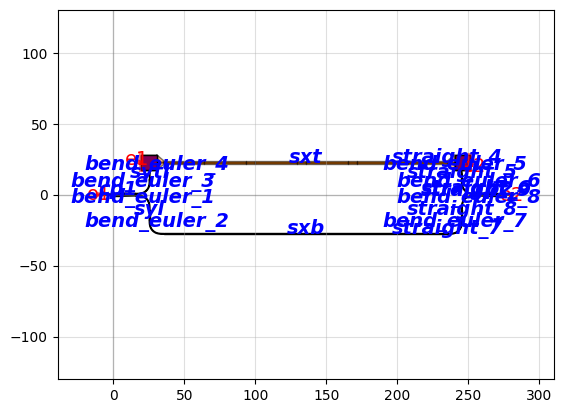

In [69]:
mzi_yaml = mzi_component.get_netlist_yaml()
mzi_component2 = gf.read.from_yaml(mzi_yaml)
fig = mzi_component2.plot(label_aliases=True)

The best way to get a deterministic name of the `instance` is naming the reference on your Pcell.

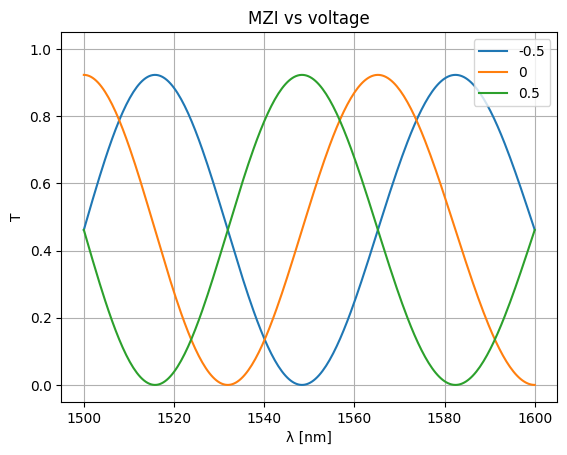

In [70]:
voltages = np.linspace(-1, 1, num=5)
voltages = [-0.5, 0, 0.5]

for voltage in voltages:
    S = mzi_circuit(
        wl=wl,
        sxt={"voltage": voltage},
    )
    plt.plot(wl * 1e3, abs(S["o1", "o2"]) ** 2, label=str(voltage))
    plt.xlabel("λ [nm]")
    plt.ylabel("T")
    plt.ylim(-0.05, 1.05)
    plt.grid(True)

plt.title("MZI vs voltage")
plt.legend()

## Optimization

You can optimize an MZI to get T=0 at 1530nm.
To do this, you need to define a loss function for the circuit at 1550nm.
This function should take the parameters that you want to optimize as positional arguments:

In [71]:
import gdsfactory as gf
import numpy as np
import sax
import matplotlib.pyplot as plt
from tqdm import trange
import jax.numpy as jnp
import jax
import jax.example_libraries.optimizers as opt

In [72]:
def straight(wl=1.5, length=10.0, neff=2.4) -> sax.SDict:
    wl0 = 1.5  # center wavelength for which the waveguide model is defined
    return sax.reciprocal({("o1", "o2"): jnp.exp(2j * jnp.pi * neff * length / wl)})


def mmi1x2():
    """Assumes a perfect 1x2 splitter"""
    return sax.reciprocal(
        {
            ("o1", "o2"): 0.5**0.5,
            ("o1", "o3"): 0.5**0.5,
        }
    )


def bend_euler(wl=1.5, length=20.0):
    """ "Let's assume a reduced transmission for the euler bend compared to a straight"""
    return {k: 0.99 * v for k, v in straight(wl=wl, length=length).items()}


models = {
    "bend_euler": bend_euler,
    "mmi1x2": mmi1x2,
    "straight": straight,
}

In [73]:
delta_length = 30
mzi_component = gf.components.mzi(delta_length=delta_length)
mzi_circuit, _ = sax.circuit(netlist=mzi_component.get_netlist(), models=models)
S = mzi_circuit(wl=1.55)
S

{
    ('o1', 'o1'): DeviceArray(0.+0.j, dtype=complex64),
    ('o2', 'o2'): DeviceArray(0.+0.j, dtype=complex64),
    ('o2', 'o1'): DeviceArray(-0.1168337-0.08663926j, dtype=complex64),
    ('o1', 'o2'): DeviceArray(-0.11683372-0.08663931j, dtype=complex64)
}

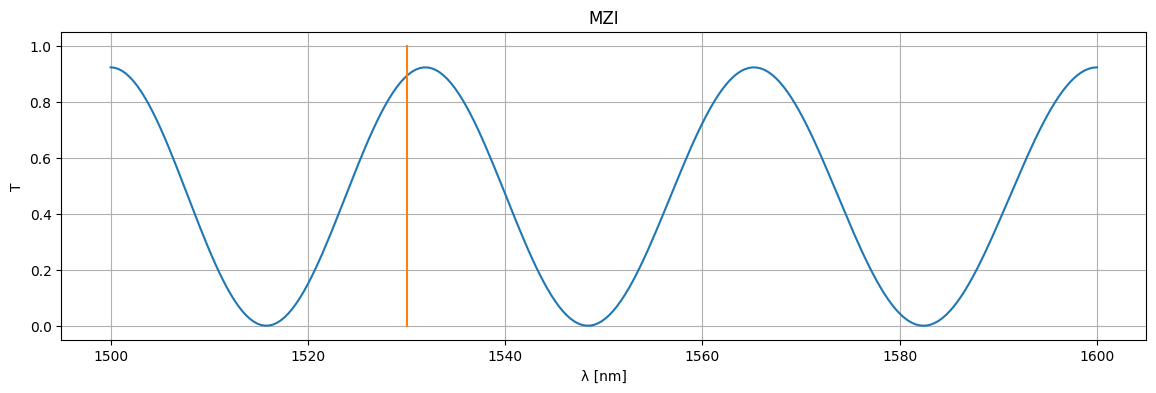

In [74]:
wl = np.linspace(1.5, 1.6, 256)
S = mzi_circuit(wl=wl)

plt.figure(figsize=(14, 4))
plt.title("MZI")
plt.plot(1e3 * wl, jnp.abs(S["o1", "o2"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.plot([1530, 1530], [0, 1])
plt.grid(True)
plt.show()

GDSFactory autonames component nanes for GDS and for netlists uses an incremental name for easier addressing.

/home/runner/work/gdsfactory/gdsfactory/gdsfactory/read/from_yaml.py:674: UserWarning: YAML defined: (bend_euler_3, bend_euler_5, bend_euler_4, straight_8, bend_euler_6, bend_euler_8, cp2, bend_euler_2, bend_euler_7, straight_5, bend_euler_1) with both connection and placement. Please use one or the other.
  warnings.warn(


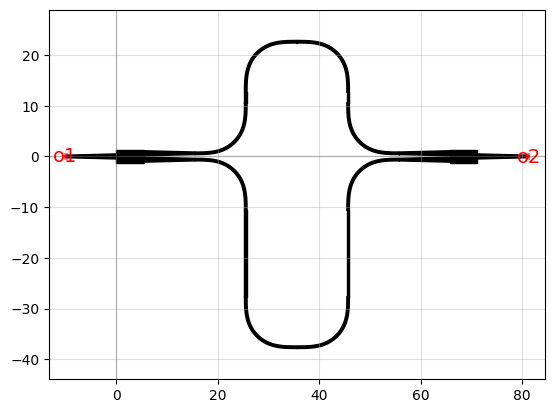

In [75]:
netlist = mzi_component.get_netlist()
c = gf.read.from_yaml(netlist)
fig = c.plot()

From this we see that we will need to change `syl` and `straight_9`.

In [76]:
mzi_component = gf.components.mzi(
    delta_length=delta_length,
)
mzi_circuit, _ = sax.circuit(
    netlist=mzi_component.get_netlist(),
    models=models,
)


@jax.jit
def loss_fn(delta_length):
    S = mzi_circuit(
        wl=1.53,
        syl={
            "length": delta_length / 2 + 2,
        },
        straight_9={
            "length": delta_length / 2 + 2,
        },
    )
    return (abs(S["o1", "o2"]) ** 2).mean()

In [77]:
%time loss_fn(20.0)

CPU times: user 6.15 s, sys: 12.1 ms, total: 6.16 s
Wall time: 6.14 s


DeviceArray(0.14018838, dtype=float32)

You can use this loss function to define a grad function which works on the parameters of the loss function:

In [78]:
grad_fn = jax.jit(
    jax.grad(
        loss_fn,
        argnums=0,  # JAX gradient function for the first positional argument, jitted
    )
)

Next, you need to define a JAX optimizer, which on its own is nothing more than three more functions:

1. an initialization function with which to initialize the optimizer state
2. an update function which will update the optimizer state (and with it the model parameters).
3. a function with the model parameters given the optimizer state.

In [79]:
initial_delta_length = 30.0
init_fn, update_fn, params_fn = opt.adam(step_size=0.1)
state = init_fn(initial_delta_length)

In [80]:
def step_fn(step, state):
    settings = params_fn(state)
    loss = loss_fn(settings)
    grad = grad_fn(settings)
    state = update_fn(step, grad, state)
    return loss, state

In [81]:
range_ = trange(100)
for step in range_:
    loss, state = step_fn(step, state)
    range_.set_postfix(loss=f"{loss:.6f}")

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:11<?, ?it/s, loss=0.891586]

  1%|          | 1/100 [00:11<19:06, 11.58s/it, loss=0.891586]

  1%|          | 1/100 [00:28<19:06, 11.58s/it, loss=0.560067]

  2%|▏         | 2/100 [00:28<24:30, 15.01s/it, loss=0.560067]

  2%|▏         | 2/100 [00:29<24:30, 15.01s/it, loss=0.163683]

  2%|▏         | 2/100 [00:29<24:30, 15.01s/it, loss=0.001276]

  2%|▏         | 2/100 [00:29<24:30, 15.01s/it, loss=0.144400]

  2%|▏         | 2/100 [00:29<24:30, 15.01s/it, loss=0.249742]

  2%|▏         | 2/100 [00:29<24:30, 15.01s/it, loss=0.226703]

  2%|▏         | 2/100 [00:29<24:30, 15.01s/it, loss=0.130105]

  2%|▏         | 2/100 [00:29<24:30, 15.01s/it, loss=0.033322]

  2%|▏         | 2/100 [00:29<24:30, 15.01s/it, loss=0.000414]

 10%|█         | 10/100 [00:29<02:55,  1.96s/it, loss=0.000414]

 10%|█         | 10/100 [00:29<02:55,  1.96s/it, loss=0.038537]

 10%|█         | 10/100 [00:29<02:55,  1.96s/it, loss=0.093221]

 10%|█         | 10/100 [00:29<02:55,  1.96s/it, loss=0.114678]

 10%|█         | 10/100 [00:29<02:55,  1.96s/it, loss=0.093450]

 10%|█         | 10/100 [00:29<02:55,  1.96s/it, loss=0.048578]

 10%|█         | 10/100 [00:29<02:55,  1.96s/it, loss=0.010156]

 10%|█         | 10/100 [00:29<02:55,  1.96s/it, loss=0.000819]

 10%|█         | 10/100 [00:29<02:55,  1.96s/it, loss=0.019582]

 18%|█▊        | 18/100 [00:29<01:12,  1.14it/s, loss=0.019582]

 18%|█▊        | 18/100 [00:29<01:12,  1.14it/s, loss=0.044813]

 18%|█▊        | 18/100 [00:29<01:12,  1.14it/s, loss=0.055284]

 18%|█▊        | 18/100 [00:29<01:12,  1.14it/s, loss=0.044983]

 18%|█▊        | 18/100 [00:29<01:12,  1.14it/s, loss=0.022833]

 18%|█▊        | 18/100 [00:29<01:12,  1.14it/s, loss=0.004353]

 18%|█▊        | 18/100 [00:29<01:12,  1.14it/s, loss=0.000629]

 18%|█▊        | 18/100 [00:29<01:12,  1.14it/s, loss=0.010565]

 18%|█▊        | 18/100 [00:29<01:12,  1.14it/s, loss=0.023149]

 26%|██▌       | 26/100 [00:29<00:36,  2.01it/s, loss=0.023149]

 26%|██▌       | 26/100 [00:29<00:36,  2.01it/s, loss=0.027602]

 26%|██▌       | 26/100 [00:29<00:36,  2.01it/s, loss=0.021162]

 26%|██▌       | 26/100 [00:29<00:36,  2.01it/s, loss=0.009429]

 26%|██▌       | 26/100 [00:29<00:36,  2.01it/s, loss=0.001069]

 26%|██▌       | 26/100 [00:29<00:36,  2.01it/s, loss=0.001088]

 26%|██▌       | 26/100 [00:29<00:36,  2.01it/s, loss=0.007340]

 26%|██▌       | 26/100 [00:29<00:36,  2.01it/s, loss=0.013223]

 26%|██▌       | 26/100 [00:29<00:36,  2.01it/s, loss=0.013644]

 34%|███▍      | 34/100 [00:29<00:20,  3.22it/s, loss=0.013644]

 34%|███▍      | 34/100 [00:29<00:20,  3.22it/s, loss=0.008668]

 34%|███▍      | 34/100 [00:29<00:20,  3.22it/s, loss=0.002599]

 34%|███▍      | 34/100 [00:29<00:20,  3.22it/s, loss=0.000001]

 34%|███▍      | 34/100 [00:29<00:20,  3.22it/s, loss=0.001984]

 34%|███▍      | 34/100 [00:29<00:20,  3.22it/s, loss=0.005744]

 34%|███▍      | 34/100 [00:29<00:20,  3.22it/s, loss=0.007519]

 34%|███▍      | 34/100 [00:29<00:20,  3.22it/s, loss=0.005848]

 34%|███▍      | 34/100 [00:29<00:20,  3.22it/s, loss=0.002422]

 42%|████▏     | 42/100 [00:29<00:11,  4.88it/s, loss=0.002422]

 42%|████▏     | 42/100 [00:29<00:11,  4.88it/s, loss=0.000160]

 42%|████▏     | 42/100 [00:29<00:11,  4.88it/s, loss=0.000560]

 42%|████▏     | 42/100 [00:29<00:11,  4.88it/s, loss=0.002595]

 42%|████▏     | 42/100 [00:29<00:11,  4.88it/s, loss=0.003991]

 42%|████▏     | 42/100 [00:29<00:11,  4.88it/s, loss=0.003442]

 42%|████▏     | 42/100 [00:29<00:11,  4.88it/s, loss=0.001593]

 42%|████▏     | 42/100 [00:29<00:11,  4.88it/s, loss=0.000163]

 42%|████▏     | 42/100 [00:29<00:11,  4.88it/s, loss=0.000231]

 50%|█████     | 50/100 [00:29<00:07,  7.11it/s, loss=0.000231]

 50%|█████     | 50/100 [00:29<00:07,  7.11it/s, loss=0.001344]

 50%|█████     | 50/100 [00:29<00:07,  7.11it/s, loss=0.002174]

 50%|█████     | 50/100 [00:29<00:07,  7.11it/s, loss=0.001886]

 50%|█████     | 50/100 [00:29<00:07,  7.11it/s, loss=0.000844]

 50%|█████     | 50/100 [00:29<00:07,  7.11it/s, loss=0.000068]

 50%|█████     | 50/100 [00:29<00:07,  7.11it/s, loss=0.000167]

 50%|█████     | 50/100 [00:29<00:07,  7.11it/s, loss=0.000819]

 57%|█████▋    | 57/100 [00:29<00:04,  9.68it/s, loss=0.000819]

 57%|█████▋    | 57/100 [00:29<00:04,  9.68it/s, loss=0.001223]

 57%|█████▋    | 57/100 [00:29<00:04,  9.68it/s, loss=0.000965]

 57%|█████▋    | 57/100 [00:29<00:04,  9.68it/s, loss=0.000356]

 57%|█████▋    | 57/100 [00:29<00:04,  9.68it/s, loss=0.000006]

 57%|█████▋    | 57/100 [00:29<00:04,  9.68it/s, loss=0.000171]

 57%|█████▋    | 57/100 [00:29<00:04,  9.68it/s, loss=0.000552]

 57%|█████▋    | 57/100 [00:29<00:04,  9.68it/s, loss=0.000683]

 64%|██████▍   | 64/100 [00:29<00:02, 12.98it/s, loss=0.000683]

 64%|██████▍   | 64/100 [00:29<00:02, 12.98it/s, loss=0.000438]

 64%|██████▍   | 64/100 [00:29<00:02, 12.98it/s, loss=0.000102]

 64%|██████▍   | 64/100 [00:29<00:02, 12.98it/s, loss=0.000007]

 64%|██████▍   | 64/100 [00:29<00:02, 12.98it/s, loss=0.000184]

 64%|██████▍   | 64/100 [00:29<00:02, 12.98it/s, loss=0.000373]

 64%|██████▍   | 64/100 [00:29<00:02, 12.98it/s, loss=0.000349]

 64%|██████▍   | 64/100 [00:29<00:02, 12.98it/s, loss=0.000154]

 71%|███████   | 71/100 [00:29<00:01, 17.15it/s, loss=0.000154]

 71%|███████   | 71/100 [00:29<00:01, 17.15it/s, loss=0.000009]

 71%|███████   | 71/100 [00:30<00:01, 17.15it/s, loss=0.000043]

 71%|███████   | 71/100 [00:30<00:01, 17.15it/s, loss=0.000172]

 71%|███████   | 71/100 [00:30<00:01, 17.15it/s, loss=0.000224]

 71%|███████   | 71/100 [00:30<00:01, 17.15it/s, loss=0.000142]

 71%|███████   | 71/100 [00:30<00:01, 17.15it/s, loss=0.000029]

 71%|███████   | 71/100 [00:30<00:01, 17.15it/s, loss=0.000005]

 78%|███████▊  | 78/100 [00:30<00:00, 22.07it/s, loss=0.000005]

 78%|███████▊  | 78/100 [00:30<00:00, 22.07it/s, loss=0.000072]

 78%|███████▊  | 78/100 [00:30<00:00, 22.07it/s, loss=0.000128]

 78%|███████▊  | 78/100 [00:30<00:00, 22.07it/s, loss=0.000105]

 78%|███████▊  | 78/100 [00:30<00:00, 22.07it/s, loss=0.000035]

 78%|███████▊  | 78/100 [00:30<00:00, 22.07it/s, loss=0.000000]

 78%|███████▊  | 78/100 [00:30<00:00, 22.07it/s, loss=0.000028]

 78%|███████▊  | 78/100 [00:30<00:00, 22.07it/s, loss=0.000070]

 85%|████████▌ | 85/100 [00:30<00:00, 27.62it/s, loss=0.000070]

 85%|████████▌ | 85/100 [00:30<00:00, 27.62it/s, loss=0.000069]

 85%|████████▌ | 85/100 [00:30<00:00, 27.62it/s, loss=0.000030]

 85%|████████▌ | 85/100 [00:30<00:00, 27.62it/s, loss=0.000001]

 85%|████████▌ | 85/100 [00:30<00:00, 27.62it/s, loss=0.000011]

 85%|████████▌ | 85/100 [00:30<00:00, 27.62it/s, loss=0.000038]

 85%|████████▌ | 85/100 [00:30<00:00, 27.62it/s, loss=0.000043]

 85%|████████▌ | 85/100 [00:30<00:00, 27.62it/s, loss=0.000021]

 92%|█████████▏| 92/100 [00:30<00:00, 33.59it/s, loss=0.000021]

 92%|█████████▏| 92/100 [00:30<00:00, 33.59it/s, loss=0.000002]

 92%|█████████▏| 92/100 [00:30<00:00, 33.59it/s, loss=0.000005]

 92%|█████████▏| 92/100 [00:30<00:00, 33.59it/s, loss=0.000021]

 92%|█████████▏| 92/100 [00:30<00:00, 33.59it/s, loss=0.000026]

 92%|█████████▏| 92/100 [00:30<00:00, 33.59it/s, loss=0.000014]

 92%|█████████▏| 92/100 [00:30<00:00, 33.59it/s, loss=0.000001]

 92%|█████████▏| 92/100 [00:30<00:00, 33.59it/s, loss=0.000003]

 99%|█████████▉| 99/100 [00:30<00:00, 39.48it/s, loss=0.000003]

 99%|█████████▉| 99/100 [00:30<00:00, 39.48it/s, loss=0.000012]

100%|██████████| 100/100 [00:30<00:00,  3.29it/s, loss=0.000012]

In [82]:
delta_length = params_fn(state)
delta_length

DeviceArray(30.282085, dtype=float32)

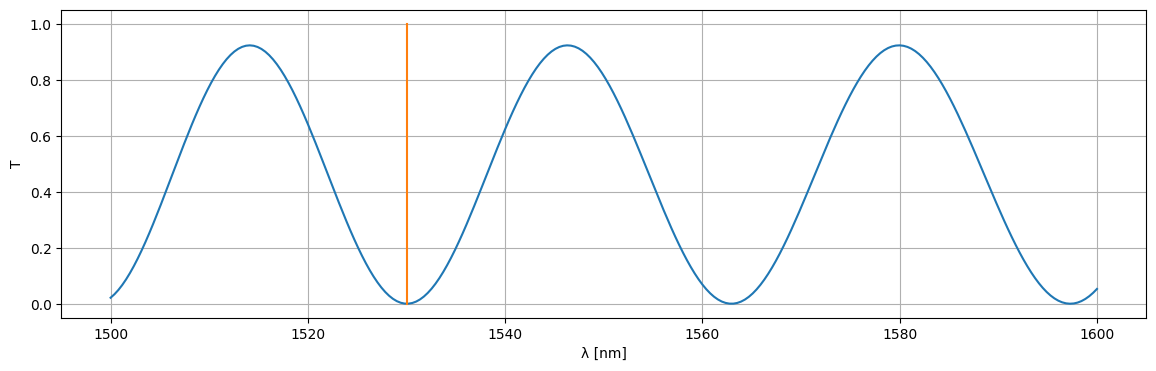

In [83]:
S = mzi_circuit(
    wl=wl,
    syl={"length": delta_length / 2 + 2},
    straight_9={"length": delta_length / 2 + 2},
)
plt.figure(figsize=(14, 4))
plt.plot(wl * 1e3, abs(S["o1", "o2"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.ylim(-0.05, 1.05)
plt.plot([1530, 1530], [0, 1])
plt.grid(True)
plt.show()

The minimum of the MZI is perfectly located at 1530nm.

## Hierarchical circuits

You can also simulate hierarchical circuits, such as lattice of MZI interferometers.

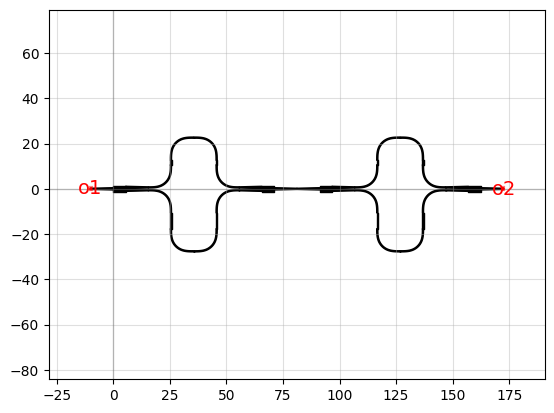

In [84]:
from typing import List

import jax.numpy as jnp
import numpy as np
import sax
import matplotlib.pyplot as plt

import gdsfactory as gf


@gf.cell
def mzis(delta_length=10):
    c = gf.Component()
    c1 = c << gf.components.mzi(delta_length=delta_length)
    c2 = c << gf.components.mzi(delta_length=delta_length)
    c2.connect("o1", c1.ports["o2"])

    c.add_port("o1", port=c1.ports["o1"])
    c.add_port("o2", port=c2.ports["o2"])
    return c


def straight(wl=1.5, length=10.0, neff=2.4) -> sax.SDict:
    """Straight model."""
    return sax.reciprocal({("o1", "o2"): jnp.exp(2j * jnp.pi * neff * length / wl)})


def mmi1x2():
    """Assumes a perfect 1x2 splitter."""
    return sax.reciprocal(
        {
            ("o1", "o2"): 0.5**0.5,
            ("o1", "o3"): 0.5**0.5,
        }
    )


def bend_euler(wl=1.5, length=20.0):
    """Assumes reduced transmission for the euler bend compared to a straight."""
    return {k: 0.99 * v for k, v in straight(wl=wl, length=length).items()}


models = {
    "bend_euler": bend_euler,
    "mmi1x2": mmi1x2,
    "straight": straight,
}


c2 = mzis()
fig = c2.plot()

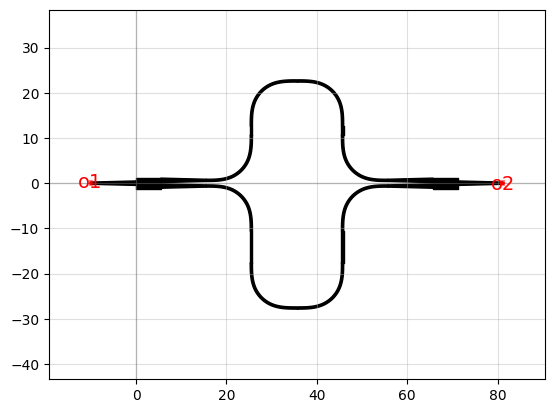

In [85]:
c1 = gf.components.mzi(delta_length=10)
fig = c1.plot()

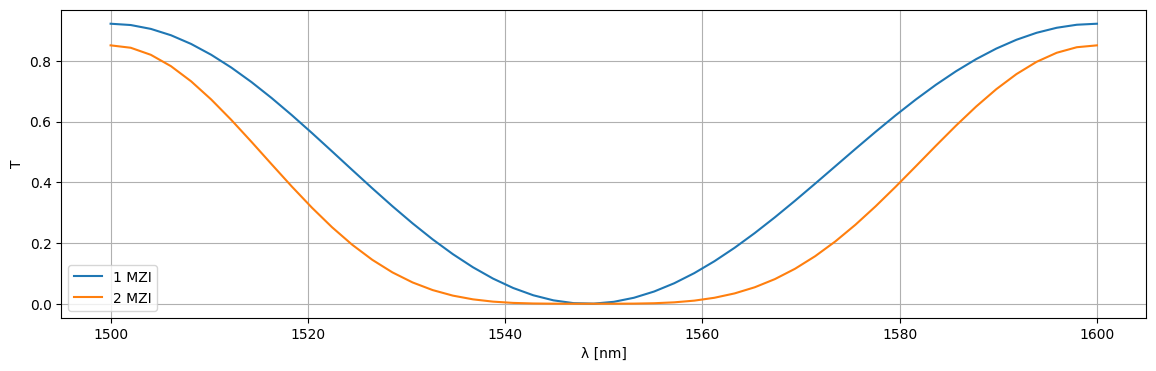

In [86]:
wl = np.linspace(1.5, 1.6)
netlist1 = c1.get_netlist_recursive()
circuit1, _ = sax.circuit(netlist=netlist1, models=models)
S1 = circuit1(wl=wl)

netlist2 = c2.get_netlist_recursive()
circuit2, _ = sax.circuit(netlist=netlist2, models=models)
S2 = circuit2(wl=wl)

plt.figure(figsize=(14, 4))
plt.plot(1e3 * wl, jnp.abs(S1["o1", "o2"]) ** 2, label="1 MZI")
plt.plot(1e3 * wl, jnp.abs(S2["o1", "o2"]) ** 2, label="2 MZI")
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.grid(True)
plt.legend()
plt.show()